본 데이터는 브라질의 병원 예약 데이터이다. 브라질에서는 예약을 하고 실제로 오지 않는 No Show가 많다고 한다. 어떤 특징을 가진 환자가 No Show가 많은지 분석하는 것이 목적이다. 단, 판다스 연습용이기 Eons에 통계를 전혀 사용하지 않았다. 본 분석만을 통해 No Show에 영향을 미치는 속성을 판단할 수는 없다 (통계적으로 유의한 결과가 아니라는 뜻이다). 그저 그래프를 보고 추측만 할 수 있을 뿐이다. 데이터 셋에는 환자에 대한 총 14개 속성 값(feature)이 있다.

-	Patient: 환자 구분자
-	AppointmentID : 예약 구분자
-	Gender: 남/녀 구분, (참고로, 여성이 남성보다 건강에 더 관심을 많이 가지기 때문에 여성 비율이 높다고 kaggle에 설명이 되어 있음)
-	ScheduledDay : 진료 예약 날짜
-	Age: 나이
-	Neighbourhood : 사는 곳
-	Scholarship: 이수함/ 이수하지 않음 구분(사회 공헌 프로그램의 일종임).
-	Hipertension : 고혈압 여부
-	Diabetes : 당뇨 여부
-	Alcoholism : 알코올 중독 여부
-	Handcap : 장애 여부
-	SMS_received : SMS 수신 여부
-	No-show : Yes or No (예약에 왔으면 ‘No’, 안왔으면 ‘Yes’)

분석에 활용할 독립변수 선택<br>
    ① Gender<br>
    ② Period between the scheduled day and appointment day<br>
    ③ Age<br>
    ④ Scholarship<br>
    ⑤ Disease (hypertension, diabetes, alcoholism) – each element is counted as 1, sum of all<br>
    ⑥ SMS-received<br>
    
종속변수는 ‘No-show’이다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Wrangling
데이터를 불러와서 클리닝하는 작업을 함

## Load a dataset
noshowappointments-kagglev2-may-2016.csv은 캐글에서 받아 올 수 있다.

In [2]:
df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# 데이터 타입과 elements 개수를 체크한다.
df.info()

# null 값이 없기 때문에 null 제거를 안해도 된다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## Remove duplicated elements
중복행이 있는지 검사함

In [4]:
df.duplicated().sum()
# 중복행이 없다.

0

## Fix the typo

In [5]:
#column 값을 보면 'handcap'이라고 오타가 있다. 이를 'handicap'으로 수정

df.rename(columns={"Handcap":"Handicap"}, inplace=True)

## Change the data type
ScheduleDay와 AppointmentDay값을 보면 날짜와 시간까지 나옴.
시간까지 고려하면 좋지만 AppointmentDay의 시간은 모두 00:00:00이기 때문에 고려할 수가 없다.

In [6]:
# 따라서 날짜, 시간 타입을 날짜만 나와있는 타입으로 변경해서 사용할 것이다.
df.AppointmentDay = pd.to_datetime(df.AppointmentDay).dt.date
df.ScheduledDay = pd.to_datetime(df.ScheduledDay).dt.date

In [7]:
# ScheduledDay와 AppointmentDay의 차이, 즉 예약을 한 시점으로부터 예약 날짜까지의 기간을 구하겠다.
# 그 기간이 짧을수록 예약날에 진료를 갈 확률이 높을 것이라고 가정을 함.

df['PeriodBetween'] = df.AppointmentDay - df.ScheduledDay

# convert derived datetime to int
df['PeriodBetween'] = df['PeriodBetween'].dt.days
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,PeriodBetween
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4.262960e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,8.679510e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8.841190e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [8]:
# No-show 칼럼에서 Yes가 예약에 안 온 것이고, No가 예약에 온 것이기 때문에 헷갈린다.
# 쉽게 판단을 위해 'No-show'를 'Show'로 바꿈
# Yes는 0, No는 1로 데이터를 바꾼다. 결과적으로 0이면 No-show, 1이면 Show 이다.

df.rename(columns={'No-show':'Show'}, inplace=True)
df.replace({'Show': {'No':1, 'Yes':0}}, inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4.262960e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,8.679510e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,8.841190e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0


## Modify nonesense value

In [9]:
# 'PeriodBetween' 속성 값 확인
df.PeriodBetween.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: PeriodBetween, dtype: float64

In [10]:
# 'PeriodBetween'는 ScheduledDay와 AppointmentDay의 차이다. 
# 음수가 있다는 건 예약당일 이후에 예약을 했다는 뜻인데 말이 안되는 데이터이다.

In [11]:
# PeriodBetween의 음수를 모두 0으로 바꾼다.
df[df['PeriodBetween'] < 0] = 0
df.PeriodBetween.describe()

count    110527.000000
mean         10.183792
std          15.254924
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: PeriodBetween, dtype: float64

In [12]:
df.Age.describe()

count    110527.000000
mean         37.087363
std          23.110888
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [13]:
# Age에도 -1이라는 이상한 값이 있다. 0으로 바꾼다.
df.replace({'Age': {-1:0}}, inplace = True)
df.Age.describe()

count    110527.000000
mean         37.087372
std          23.110873
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [14]:
# Gender 속성 확인
df.groupby('Gender').mean()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween
Gender,,,,,,,,,,,
0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F,1.460053e+14,5.674337e+06,38.893927,0.123237,0.213525,0.078038,0.017025,0.019530,0.336902,0.796887,10.502248
M,1.502570e+14,5.677103e+06,33.737443,0.051906,0.167041,0.060411,0.055241,0.027246,0.291586,0.800362,9.593744


In [15]:
# Gender 속성에 'F', 'M'외에 0이라는 값이 있다.
# 이 값을 가지고 있는 행은 모두 삭제
null_containing_rows_index = df[df.Gender == 0].index
df.drop(index = null_containing_rows_index, inplace=True)
df.Gender.describe()

count     110522
unique         2
top            F
freq       71837
Name: Gender, dtype: object

## Segment PeriodBetween values into bins

In [16]:
# 'PeriodBetween' 속성의 최대값은 179 최소값은 0이다. 
# 범위가 상당히 크기 때문에 4개의 카테고리로 나누겠다.
# 카테고리는 (-1, 1), (1, 5), (5, 10), (10, 200)로 임의로 정함.
# 카테고리의 규격이 일정하지 않은 이유는 0에 가까울 수록 테이터가 많기 때문이다.

bins = pd.IntervalIndex.from_tuples([(-1, 1), (1, 5), (5, 10), (10, 200)])
labels = ["rightNow", "fewDaysAgo", "severalDayAgo", "longAgo"]
df['PeriodBetween'] = pd.cut(df['PeriodBetween'], bins = bins, labels = labels) 

In [17]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,"(-1, 1]"
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,"(-1, 1]"
2,4.262960e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,"(-1, 1]"
3,8.679510e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,"(-1, 1]"
4,8.841190e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,"(-1, 1]"


## Segment Age values into bins

In [18]:
bins = pd.IntervalIndex.from_tuples([(0, 18), (18, 37), (37, 55), (55, 115)])
df['Age'] = pd.cut(df['Age'], bins = bins) 
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,"(55, 115]",JARDIM DA PENHA,0,1,0,0,0,0,1,"(-1, 1]"
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,"(55, 115]",JARDIM DA PENHA,0,0,0,0,0,0,1,"(-1, 1]"
2,4.262960e+12,5642549,F,2016-04-29,2016-04-29,"(55, 115]",MATA DA PRAIA,0,0,0,0,0,0,1,"(-1, 1]"
3,8.679510e+11,5642828,F,2016-04-29,2016-04-29,"(0, 18]",PONTAL DE CAMBURI,0,0,0,0,0,0,1,"(-1, 1]"
4,8.841190e+12,5642494,F,2016-04-29,2016-04-29,"(55, 115]",JARDIM DA PENHA,0,1,1,0,0,0,1,"(-1, 1]"


## Remove unnecessary columns
분석에 필요하지 않은 속성은 모두 제거

In [19]:
df.drop(columns=['Neighbourhood', 'ScheduledDay', 'AppointmentDay'], inplace=True)
df.head()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween
0,2.987250e+13,5642903,F,"(55, 115]",0,1,0,0,0,0,1,"(-1, 1]"
1,5.589980e+14,5642503,M,"(55, 115]",0,0,0,0,0,0,1,"(-1, 1]"
2,4.262960e+12,5642549,F,"(55, 115]",0,0,0,0,0,0,1,"(-1, 1]"
3,8.679510e+11,5642828,F,"(0, 18]",0,0,0,0,0,0,1,"(-1, 1]"
4,8.841190e+12,5642494,F,"(55, 115]",0,1,1,0,0,0,1,"(-1, 1]"


## Exploratory Data Analysis

### Question 1 - 예약 신청 날짜와 예약 당일 간의 기간이 No Show에 영향을 미치는가?
Groupby를 활용하여 'PeriodBetween'의 영향을 보겠다.

In [20]:
df_PeriodBetween = df.groupby('PeriodBetween').mean()['Show']
df_PeriodBetween.head()

PeriodBetween
(-1, 1]      0.933639
(1, 5]       0.758778
(5, 10]      0.729521
(10, 200]    0.674853
Name: Show, dtype: float64

예약 신청 날짜가 예약 당일과 가까울 수록 No Show확률이 적은 경향이 있다.
단, 데이터 결과가 그렇게 나왔다는 것이지 통계적으로 유의하다는 뜻은 아니다.
plot을 여러번 사용할 것이므로 간단히 function으로 만든다.

In [21]:
def draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel):
    plt.bar(locations, heights, tick_label = labels)
    plt.title(chartTitle)
    plt.xlabel(chartXlabel)
    plt.ylabel(chartYlabel);

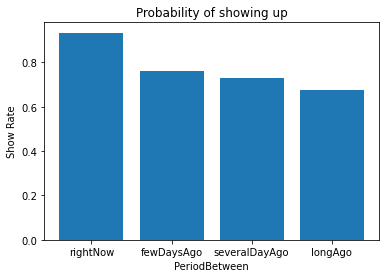

In [22]:
locations = [1,2,3,4]
heights = df_PeriodBetween
labels = ["rightNow", "fewDaysAgo", "severalDayAgo", "longAgo"]
chartTitle = 'Probability of showing up'
chartXlabel = 'PeriodBetween'
chartYlabel = 'Show Rate'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

## Question 2 - 성별이 No Show에 영향을 미치는가?

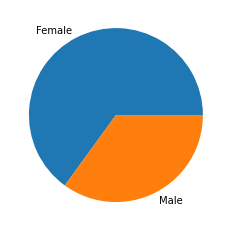

In [23]:
# 우선 남녀 비율이 어떻게 되는지 본다
plt.pie(df.Gender.value_counts(), labels=['Female', 'Male']);

In [24]:
# 여자가 더 많은 예약을 했다.
df_Gender = df.groupby('Gender').mean()['Show']
df_Gender

Gender
F    0.796887
M    0.800362
Name: Show, dtype: float64

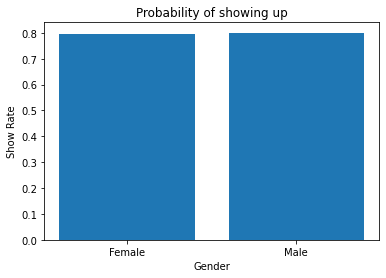

In [25]:
locations = [1,2]
heights = df_Gender
labels = ['Female', 'Male']
chartXlabel = 'Gender'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

 남녀 간의 No Show 차이는 거의 없다.
 
 
## Question 3 - 나이가 No Show에 영향을 미치는가?

In [26]:
df_age = df.groupby('Age').mean()['Show']
df_age

Age
(0, 18]      0.774658
(18, 37]     0.764680
(37, 55]     0.804720
(55, 115]    0.843581
Name: Show, dtype: float64

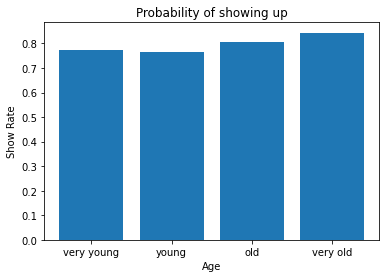

In [27]:
locations = [1,2,3,4]
heights = df_age
labels = ['very young', 'young', 'old', 'very old']
chartXlabel = 'Age'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

나이가 많을 수록 No Show 확률이 적다.

## Question 4 - 브라질 scholarship이 No Show에 영향에 미치는가?

In [28]:
df_scholarship = df.groupby('Scholarship').mean()['Show']
df_scholarship

Scholarship
0    0.801969
1    0.762637
Name: Show, dtype: float64

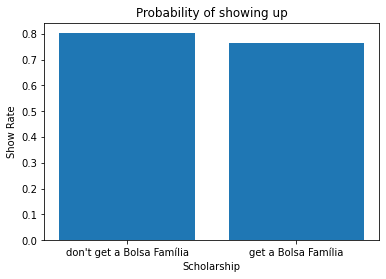

In [29]:
locations = [1,2]
heights = df_scholarship
labels = ["don't get a Bolsa Família", "get a Bolsa Família"]
chartXlabel = 'Scholarship'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

브라질의 scholarship인 Bolsa Familia를 받은 사람들의 No Show 확률이 높다.


## Question 5 - 질병이 No Show에 영향을 미치는가?

In [36]:
# Let Disease be the sum of Hipertension, Diabetes and Alcoholism

df['Disease'] = df['Hipertension'] + df['Diabetes'] + df['Alcoholism']

df_disease = df.groupby('Disease').mean()['Show']
df_disease

df.drop(columns=['df_disease'], inplace = True)
df.head()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,PeriodBetween,Disease
0,2.987250e+13,5642903,F,"(55, 115]",0,1,0,0,0,0,1,"(-1, 1]",1
1,5.589980e+14,5642503,M,"(55, 115]",0,0,0,0,0,0,1,"(-1, 1]",0
2,4.262960e+12,5642549,F,"(55, 115]",0,0,0,0,0,0,1,"(-1, 1]",0
3,8.679510e+11,5642828,F,"(0, 18]",0,0,0,0,0,0,1,"(-1, 1]",0
4,8.841190e+12,5642494,F,"(55, 115]",0,1,1,0,0,0,1,"(-1, 1]",2


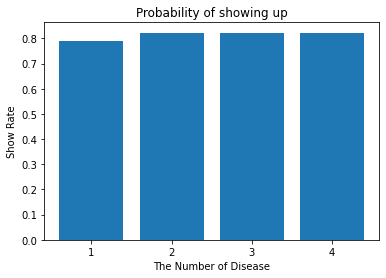

In [33]:
locations = [1,2,3,4]
heights = df_disease
labels = [1,2,3,4]
chartXlabel = 'The Number of Disease'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

질병의 수가 많을 수록 No show 확률이 적다.


## Question 6 - 장애가 No Show에 영향을 미치는가?

In [38]:
df_handicap = df.groupby('Handicap').mean()['Show']
df_handicap

Handicap
0    0.797669
1    0.821569
2    0.797814
3    0.769231
4    0.666667
Name: Show, dtype: float64

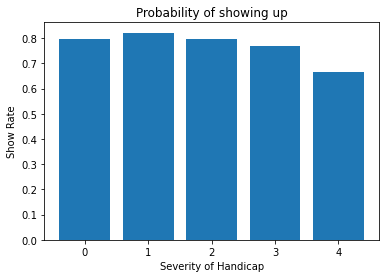

In [39]:
locations = [1,2,3,4,5]
heights = df_handicap
labels = [0,1,2,3,4]
chartXlabel = 'Severity of Handicap'

draw_plot(locations, heights, labels, chartTitle, chartXlabel, chartYlabel);

장애 수치가 높을 수록 No Show 확률이 높다.
단, 0일때 No Show 확률이 가장 낮지는 않다.

Conclusions
나이, 질병 수치가 높을 수록 No Show 확률이 작으며, 
PeriodBetween, Scholarship 수치가 높을 수록 No Show 확률이 높다.
이 분석은 판다스를 활용해보는데 의의를 둠.
통계적 검증을 하지 않았기 때문에 경향성을 말할 수는 없다.